In [151]:
%matplotlib inline
%config InlineBackend.figure_format='svg'
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import pandas as pd
import os
# import chain

from operator import attrgetter
from matplotlib.colors import LinearSegmentedColormap
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from itertools import chain

from os.path import isfile, join

saveFigures = True
plt.rcParams['figure.figsize'] = (18, 6)
plt.rcParams['figure.dpi'] = 300

asdf

In [152]:
# These functions are used for data analysis.

# these functions are used in determining the type
# of data we are looking at (posthresh, neghold etc)
def is_increasing(L):
    return L[0] < L[len(L) - 1] and len(L) > 1
def is_decreasing(L):
    return L[0] > L[len(L) - 1] and len(L) > 1
def non_increasing(L):
    return all(x>=y for x, y in zip(L, L[1:]))
def non_decreasing(L):
    return all(x<=y for x, y in zip(L, L[1:]))
def monotonic(L):
    return non_increasing(L) or non_decreasing(L)
def average(array):
    return sum(array) / len(array)

# this will return the type of data you give it
# it takes an array of [voltages] and [currents] as arguments
def sort_into_side(voltage, current):
    if is_increasing(voltage) and is_increasing(current):
        return "posThresh"
    elif is_decreasing(voltage) and is_decreasing(current):
        return "posHold"
    elif is_decreasing(voltage) and is_increasing(current):
        return "negThresh"
    elif is_increasing(voltage) and is_decreasing(current):
        return "negHold"
    else: 
        print("???")
        # print("error determining type of data. V: ", voltage, " I: ", current)

def get_rand_id():
    return np.random.randint(1000000000)



asdf

In [153]:
class Graph: 
    def __init__(self, title, xlabel, ylabel, hlines, type_of_graph, data_to_graph, points):
        self.title = title
        self.xlabel = xlabel
        self.ylabel = ylabel
        self.hlines = hlines
        self.type = type_of_graph
        self.data_to_graph = data_to_graph
        self.points = points
        self.color_pool = ['blue', 'red', 'orange', 'green', 'magenta', 'black', 'yellow', 'blue', 'red', 'orange', 'green', 'magenta', 'black', 'yellow']
        self.show()

    def show(self):
        plt.title(self.title)
        plt.xlabel(self.xlabel)
        plt.ylabel(self.ylabel)
        

        if self.type == "box":
            print(self.data_to_graph)
            plt.boxplot(self.data_to_graph, labels=self.points)
        else:
            plt.grid()
            for i in range(len(self.data_to_graph) - 0):
                x = self.data_to_graph[i][0]
                y = self.data_to_graph[i][1]
                color = self.color_pool[0]
                if self.type == "semilogy":
                    plt.semilogy(x, y, color=color)
                elif self.type == "plot":
                    plt.plot(x, y, color=color)
                elif self.type == "box":
                    plt.boxplot(x, y, color=color)
                    
            for i in range(len(self.hlines)):
                plt.axhline(y = self.hlines[i], color = 'r', linestyle = '-')

            for i in range(len(self.points)):
                plt.plot(self.points[i][0], self.points[i][1], marker="o", markersize=10, markeredgecolor=self.color_pool[i], markerfacecolor=self.color_pool[i])
        
        if saveFigures: 
            plt.savefig('figures/' + self.title[:30] + '.png', bbox_inches='tight')
        plt.figure(get_rand_id())
        plt.show()

asdf

In [154]:
def read_file_data(data):
    # REMOVE BAD DATA: read all the data and remove the rows when we are very close to the max current
    rows_to_exclude = pd.read_csv(data.filePath, names=['Time (s)','Current (A)','Voltage (V)', 'Temperature (K)'], sep='\t',skiprows=1)
    data_from_file = rows_to_exclude.values
    rows_to_exclude.head()
    I_to_skip = data_from_file[:,1]
    # the cut off value for the max current is 0.9999999 * the highest current recorded in the file
    max_current = np.max(I_to_skip) * 0.9999999
    print("max current: ", max_current)
    over_max_current_indexes = ((I_to_skip > max_current).nonzero())[0]
    # read the file again without the rows that have a current above the threshold
    df5 = pd.read_csv(data.filePath, names=['Time (s)','Current (A)','Voltage (V)', 'Temperature (K)'], sep='\t',skiprows=over_max_current_indexes)
    # df5.head()
    return df5.values

def createDataDictionary(data, start, stop):
    dI = np.gradient(data.I[start:stop])
    ddI = np.gradient(np.gradient(data.I[start:stop]))
    run_temp = np.average(data.temps[start:stop])
    run_temp_std = np.std(data.temps[start:stop])
    return {
        'time': data.time[start:stop],
        'I': data.I[start:stop],
        'R': data.R[start:stop],
        'dI': dI,
        'ddI': ddI,
        'V': data.V[start:stop],
        'temps': data.temps[start:stop],
        'temp': run_temp,
        'temp_std': run_temp_std,
        'type_of_data': sort_into_side(data.V[start:stop], data.I[start:stop]),
        'max_ddI': np.argmax(ddI),
    }


def count_IV_curves(data):
    pos_thresh_IV_curve_count = 0
    pos_hold_IV_curve_count = 0
    neg_thresh_IV_curve_count = 0
    neg_hold_IV_curve_count = 0
    for IV_curve in data.IV_curves:
        if IV_curve['type_of_data'] == "posThresh":
            pos_thresh_IV_curve_count += 1
        if IV_curve['type_of_data'] == "negThresh":
            neg_thresh_IV_curve_count += 1
        if IV_curve['type_of_data'] == "posHold":
            pos_hold_IV_curve_count += 1
        if IV_curve['type_of_data'] == "negHold":
            neg_hold_IV_curve_count += 1
    return [pos_thresh_IV_curve_count, pos_hold_IV_curve_count, neg_thresh_IV_curve_count, neg_hold_IV_curve_count]

In [155]:
# this will take a file name
# get all of the meaningful stuff out of it
class DataFile:
    def __init__(self, file_path):
        self.pos_hold_voltages = []
        self.neg_hold_voltages = []

        self.pos_thresh_voltages = []
        self.neg_thresh_voltages = []
        self.filePath = file_path
        print("file pathsasd: ", self.filePath)
        self.get_file_name_from_path()
        self.get_device_number_from_name()
        self.get_sample_number_from_name()
        self.read_all_data()
        self.break_all_data_into_IV_curves()
        self.count_IV_curve_types()

    def get_file_name_from_path(self):
        self.file_name = self.filePath.split("/GitHub/NbO2-Fall-23/summerData/")[1]

    def get_device_number_from_name(self):
        self.device_number = self.file_name.split("_")[4]

    def get_sample_number_from_name(self):
        self.sample_number = self.file_name.split("_")[3]

    def read_all_data(self):

        data = read_file_data(self)
        
        self.number_of_data_points = len(data[:,0])
        print("number of data points: ", self.number_of_data_points)
        
        interval = 1
        self.time = np.arange(0, len(data[:,0])) * interval

        self.I = data[:,1]
        self.V = data[:,2]
        self.temps = data[:,3]

        self.R = self.V / self.I
        self.R = np.abs(self.R)

    def graph_all_data(self):
        the_graph = Graph(
            "All Data",         # title
            "Voltage (V)",      # xlabel
            "Current (A)",      # ylabel
            [], # hlines
            "semilogy",         # type of graph
            [[self.V, self.I]],   # data to graph
            [],                 # points
        )

    def break_all_data_into_IV_curves(self):
        # get the index of every "0" value in the voltage array
        self.all_zero_indexes = np.where(self.V == 0.0)[0]

        # removing the frist and last 4 reduces the number of crashes
        self.all_zero_indexes = self.all_zero_indexes[4:]
        self.all_zero_indexes = self.all_zero_indexes[:-4]

        self.IV_curves = []
        self.all_data_in_runs = []

        # gets the following data out of the file: 'I' 'R' 'dI' 'ddI' 'V' 'temps' 'temp' 'temp_std' 'type_of_data' 'max_ddI' and stores it ina dictionary
        for i in range(len(self.all_zero_indexes) - 1):
            start = self.all_zero_indexes[i]
            stop = (int)(start + ((self.all_zero_indexes[i+1] - start) / 2))
            self.IV_curves.append(createDataDictionary(self, start, stop))

            start = (int)(self.all_zero_indexes[i] + ((self.all_zero_indexes[i+1] - start) / 2))
            stop = self.all_zero_indexes[i+1]
            self.IV_curves.append(createDataDictionary(self, start, stop))

        self.number_of_IV_curves = (len(self.IV_curves) - 1) * 1
        print("number of IV curves: ", self.number_of_IV_curves)

    def count_IV_curve_types(self):
        iv_curve_types = count_IV_curves(self)

        print("pos_thresh_IV_curve_count: ", iv_curve_types[0])
        print("pos_hold_IV_curve_count: ", iv_curve_types[1])
        print("neg_thresh_IV_curve_count: ", iv_curve_types[2])
        print("neg_hold_IV_curve_count: ", iv_curve_types[3])

    def graph_IV_curve(self, index):
        title_time = "  Time =" + str(round(self.IV_curves[index]['time'][0])) + " s"
        title_temp = "  Temp =" + str(round(self.IV_curves[index]['temp'])) + " K" + " Std: " + str(round(self.IV_curves[index]['temp_std'], 3))
        title = "IV curve # " + str(index) + title_time + title_temp

        data_to_graph = []
        points_to_graph = []

        for i in range(4):
            voltage = self.IV_curves[index + i]['V']
            current = self.IV_curves[index + i]['I']
            data_to_graph.append([voltage, current])

            fine_tune = 0
            type_of_data = self.IV_curves[index + i]['type_of_data']
            if type_of_data == "posThresh":
                fine_tune = 1
            if type_of_data == "negThresh":
                fine_tune = 1
            if type_of_data == "posHold":
                fine_tune = -2
            if type_of_data == "negHold":
                fine_tune = -2
            
            index_to_graph = self.IV_curves[index + i]['max_ddI'] + fine_tune
            points_to_graph.append([voltage[index_to_graph], current[index_to_graph]])

        the_graph = Graph(
            title,              # title
            "Voltage (V)",      # xlabel
            "Current (A)",      # ylabel
            [],                 # hlines
            "semilogy",         # type of graph
            data_to_graph,      # data to graph
            points_to_graph,    # points
        )


    def graph_IV_curves(self, number_of_graphs):
        for x in range(0, number_of_graphs):
            i = (int)(((self.number_of_IV_curves) / number_of_graphs) * x)
            self.graph_IV_curve(i)


    def graph_IV_curves_at_temp(self, start, stop):
        for i in range(0, len(self.IV_curves) - 1, 4):
            temp = self.IV_curves[i]['temp']
            if temp > start and temp < stop: 
                self.graph_IV_curve(i)

    def graph_voltage_vs_temp_type(self, type_of_data):
        xAxis = []
        yAxis = []

        xAxis2 = []
        yAxis2 = []

        xAxis3 = []
        yAxis3 = []

        xAxis4 = []
        yAxis4 = []

        for IV_curve in self.IV_curves:
            if IV_curve['type_of_data'] == "posThresh":
                temp = IV_curve['temp']
                resistance = IV_curve['R'][IV_curve['max_ddI']]
                voltage = IV_curve['V'][IV_curve['max_ddI']]
                xAxis.append(temp)
                yAxis.append(abs(voltage))

        for IV_curve in self.IV_curves:
            if IV_curve['type_of_data'] == "negThresh":
                temp = IV_curve['temp']
                resistance = IV_curve['R'][IV_curve['max_ddI']]
                voltage = IV_curve['V'][IV_curve['max_ddI']]
                xAxis2.append(temp)
                yAxis2.append(abs(voltage))

        for IV_curve in self.IV_curves:
            if IV_curve['type_of_data'] == "posHold":
                temp = IV_curve['temp']
                resistance = IV_curve['R'][IV_curve['max_ddI']]
                voltage = IV_curve['V'][IV_curve['max_ddI']]
                xAxis3.append(temp)
                yAxis3.append(abs(voltage))

        for IV_curve in self.IV_curves:
            if IV_curve['type_of_data'] == "negHold":
                temp = IV_curve['temp']
                resistance = IV_curve['R'][IV_curve['max_ddI']]
                voltage = IV_curve['V'][IV_curve['max_ddI']]
                xAxis4.append(temp)
                yAxis4.append(abs(voltage))

        data_to_graph = [[xAxis, yAxis], [xAxis2, yAxis2], [xAxis3, yAxis3], [xAxis4, yAxis4]]

        # print(xAxis)

        the_graph = Graph(
            self.file_name +  " Special Voltage vs Temperature",   # title
            "Resistance (Ω)",                             # xlabel
            "Voltage (V)",                          # ylabel
            [],                                     # hlines
            "plot",                             # type of graph
            data_to_graph,                          # data to graph
            [],                                     # points
        )


    def graph_voltage_vs_resistance(self):
        xAxis = []
        yAxis = []

        xAxis2 = []
        yAxis2 = []

        xAxis3 = []
        yAxis3 = []

        xAxis4 = []
        yAxis4 = []

        for IV_curve in self.IV_curves:
            if IV_curve['type_of_data'] == "posThresh":
                temp = IV_curve['temp']
                resistance = IV_curve['R'][IV_curve['max_ddI']]
                voltage = IV_curve['V'][IV_curve['max_ddI']]
                xAxis.append(resistance)
                yAxis.append(abs(voltage))

        for IV_curve in self.IV_curves:
            if IV_curve['type_of_data'] == "negThresh":
                temp = IV_curve['temp']
                resistance = IV_curve['R'][IV_curve['max_ddI']]
                voltage = IV_curve['V'][IV_curve['max_ddI']]
                xAxis2.append(resistance)
                yAxis2.append(abs(voltage))

        for IV_curve in self.IV_curves:
            if IV_curve['type_of_data'] == "posHold":
                temp = IV_curve['temp']
                resistance = IV_curve['R'][IV_curve['max_ddI']]
                voltage = IV_curve['V'][IV_curve['max_ddI']]
                xAxis3.append(resistance)
                yAxis3.append(abs(voltage))

        for IV_curve in self.IV_curves:
            if IV_curve['type_of_data'] == "negHold":
                temp = IV_curve['temp']
                resistance = IV_curve['R'][IV_curve['max_ddI']]
                voltage = IV_curve['V'][IV_curve['max_ddI']]
                xAxis4.append(resistance)
                yAxis4.append(abs(voltage))

        data_to_graph = [[xAxis, yAxis], [xAxis2, yAxis2], [xAxis3, yAxis3], [xAxis4, yAxis4]]

        # print(xAxis)

        the_graph = Graph(
            self.file_name +  " Special Voltage vs Resistance",   # title
            "Resistance (Ω)",                             # xlabel
            "Voltage (V)",                          # ylabel
            [],                                     # hlines
            "plot",                             # type of graph
            data_to_graph,                          # data to graph
            [],                                     # points
        )


    def graph_voltage_vs_temp(self):
        xAxis_posThresh = []
        yAxis_posThresh = []

        xAxis_negThresh = []
        yAxis_negThresh = []

        xAxis_posHold = []
        yAxis_posHold = []

        xAxis_negHold = []
        yAxis_negHold = []

        for IV_curve in self.IV_curves:
            temp = IV_curve['temp']
            current = IV_curve['I'][IV_curve['max_ddI']]
            if IV_curve['type_of_data'] == "posThresh":
                xAxis_posThresh.append(temp)
                yAxis_posThresh.append(current)
            if IV_curve['type_of_data'] == "negThresh":
                xAxis_negThresh.append(temp)
                yAxis_negThresh.append(current)
            if IV_curve['type_of_data'] == "posHold":
                xAxis_posHold.append(temp)
                yAxis_posHold.append(current)
            if IV_curve['type_of_data'] == "negHold":
                xAxis_negHold.append(temp)
                yAxis_negHold.append(current)

        data_to_graph = [
            [xAxis_posThresh, yAxis_posThresh],
            [xAxis_negThresh, yAxis_negThresh],
            [xAxis_posHold, yAxis_posHold],
            [xAxis_negHold, yAxis_negHold],
            ]

        the_graph = Graph(
            self.file_name +  " Special Voltage vs Temp",   # title
            "Temp (K)",                             # xlabel
            "Voltage (V)",                          # ylabel
            [],                                     # hlines
            "plot",                             # type of graph
            data_to_graph,                          # data to graph
            [],                                     # points
        )

    def return_voltage_vs_temp(self):
        yAxis_posThresh = []

        yAxis_negThresh = []

        yAxis_posHold = []

        yAxis_negHold = []

        for IV_curve in self.IV_curves:
            current = IV_curve['I'][IV_curve['max_ddI']]
            if IV_curve['type_of_data'] == "posThresh":
                yAxis_posThresh.append(current)
            if IV_curve['type_of_data'] == "negThresh":
                yAxis_negThresh.append(current)
            if IV_curve['type_of_data'] == "posHold":
                yAxis_posHold.append(current)
            if IV_curve['type_of_data'] == "negHold":
                yAxis_negHold.append(current)

        data_to_graph = [
            yAxis_posThresh,
            yAxis_negThresh,
            yAxis_posHold,
            yAxis_negHold
            ]

        return data_to_graph

    def graph_resistance_vs_temp(self, voltage_to_plot, type_of_data):

        data_to_graph = [[], []]

        data_to_graph[0] = []
        data_to_graph[1] = []

        for i in range(2, len(self.V) - 2):
            voltageAtPoint = abs(self.V[i])
            if voltageAtPoint > voltage_to_plot * 0.96 and voltageAtPoint < voltage_to_plot * 1.04 and sort_into_side(self.V[i-3:i+3], self.I[i-3:i+3]) == type_of_data:
                # print()
                data_to_graph[0].append(self.temps[i])
                data_to_graph[1].append(self.R[i])

        the_graph = Graph(
            type_of_data + " Resistance vs Temp at " + str(voltage_to_plot) + " V",   # title
            "Temp (K)",                             # xlabel
            "Resistance (V)",                          # ylabel
            [],                                     # hlines
            "semilogy",                             # type of graph
            [data_to_graph],                          # data to graph
            [],                                     # points
        )

    def graph_resistance_vs_temp_123(self):

        oneOverTemp = []
        for temp in self.temps:
            oneOverTemp.append(1 / temp)
        data_to_graph = [oneOverTemp, self.R]
        the_graph = Graph(
            "Log R vs 1/T",   # title
            "Temp (K)",                             # xlabel
            "Resistance (V)",                          # ylabel
            [],                                     # hlines
            "semilogy",                             # type of graph
            [data_to_graph],                          # data to graph
            [],                                     # points
        )

    def get_voltages_of_type(self, typeOfData):

        data_to_graph = []
        xAxis = []
        yAxis = []

        for i in range(len(self.IV_curves) - 1):

            if self.IV_curves[i]['type_of_data'] == typeOfData:

                fine_tune = 0
                if typeOfData == "posThresh":
                    fine_tune = 1
                if typeOfData == "negThresh":
                    fine_tune = 1
                if typeOfData == "posHold":
                    fine_tune = -2
                if typeOfData == "negHold":
                    fine_tune = -2
            
                index_to_graph = self.IV_curves[i]['max_ddI'] + fine_tune - 1
                x = self.IV_curves[i]['temps'][index_to_graph]
                y = self.IV_curves[i]['R'][index_to_graph]
                xAxis.append(x)
                yAxis.append(y)

                data_to_graph = [xAxis, yAxis]

        return [data_to_graph]

asdf

file pathsasd:  c:/Users/Ted Mburu/Documents/GitHub/NbO2-Fall-23/summerData/IVs_NbO2_Ti0_2nd_Sam7_080823_D6_100K_5ms_0msbreak.txt
max current:  0.0010000508999949002
number of data points:  20399
number of IV curves:  185
pos_thresh_IV_curve_count:  47
pos_hold_IV_curve_count:  47
neg_thresh_IV_curve_count:  46
neg_hold_IV_curve_count:  46
file pathsasd:  c:/Users/Ted Mburu/Documents/GitHub/NbO2-Fall-23/summerData/IVs_NbO2_Ti0_2nd_Sam7_080823_D6_100K_50ms_0msbreak.txt
max current:  0.0010000518999948
number of data points:  20400
number of IV curves:  185
pos_thresh_IV_curve_count:  47
pos_hold_IV_curve_count:  47
neg_thresh_IV_curve_count:  46
neg_hold_IV_curve_count:  46
file pathsasd:  c:/Users/Ted Mburu/Documents/GitHub/NbO2-Fall-23/summerData/IVs_NbO2_Ti0_2nd_Sam7_080823_D6_100K_100ms_0msbreak.txt
max current:  0.0010000528999947
number of data points:  20400
number of IV curves:  185
pos_thresh_IV_curve_count:  47
pos_hold_IV_curve_count:  47
neg_thresh_IV_curve_count:  46
neg_ho

max current:  0.0010000538999946
number of data points:  20400
number of IV curves:  185
pos_thresh_IV_curve_count:  47
pos_hold_IV_curve_count:  47
neg_thresh_IV_curve_count:  46
neg_hold_IV_curve_count:  46
file pathsasd:  c:/Users/Ted Mburu/Documents/GitHub/NbO2-Fall-23/summerData/IVs_NbO2_Ti0_2nd_Sam7_080823_D6_100K_500ms_500msbreak.txt
max current:  0.0010000998999900002
number of data points:  20400
number of IV curves:  185
pos_thresh_IV_curve_count:  47
pos_hold_IV_curve_count:  47
neg_thresh_IV_curve_count:  46
neg_hold_IV_curve_count:  46
file pathsasd:  c:/Users/Ted Mburu/Documents/GitHub/NbO2-Fall-23/summerData/IVs_NbO2_Ti0_2nd_Sam7_080823_D6_100K_500ms_1000msbreak.txt
max current:  0.0010000548999945
number of data points:  20400
number of IV curves:  185
pos_thresh_IV_curve_count:  47
pos_hold_IV_curve_count:  47
neg_thresh_IV_curve_count:  46
neg_hold_IV_curve_count:  46
[[8.354776e-05, 8.335106e-05, 8.373903e-05, 8.342108e-05, 8.333586e-05, 8.329012e-05, 8.340173e-05, 8

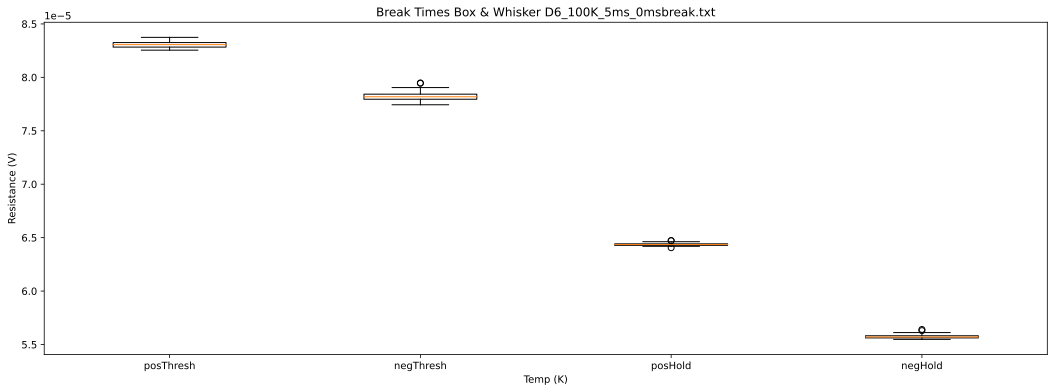

<Figure size 5400x1800 with 0 Axes>

[[8.556191e-05, 8.560307e-05, 8.562819e-05, 8.551556e-05, 8.54947e-05, 8.540586e-05, 8.542863e-05, 8.521709e-05, 8.548911e-05, 8.560377e-05, 8.562976e-05, 8.561832e-05, 8.567444e-05, 8.552751e-05, 8.533054e-05, 8.547081e-05, 8.537607e-05, 8.531436e-05, 8.539761e-05, 8.502189e-05, 8.496184e-05, 8.534169e-05, 8.490602e-05, 8.517961e-05, 8.544479e-05, 8.506885e-05, 8.518381e-05, 8.518712e-05, 8.50431e-05, 8.511694e-05, 8.503499e-05, 8.488537e-05, 8.502718e-05, 8.500274e-05, 8.496302e-05, 8.496207e-05, 8.491393e-05, 8.501729e-05, 8.48891e-05, 8.507047e-05, 8.49008e-05, 8.472443e-05, 8.481048e-05, 8.472408e-05, 8.500828e-05, 8.495579e-05, 8.488652e-05], [8.082954e-05, 8.04023e-05, 8.02476e-05, 8.002485e-05, 8.002678e-05, 8.014583e-05, 7.988855e-05, 7.970574e-05, 8.000388e-05, 7.977828e-05, 7.94423e-05, 8.017702e-05, 7.949457e-05, 7.999803e-05, 7.971775e-05, 7.933551e-05, 7.966156e-05, 7.935517e-05, 7.971361e-05, 7.931938e-05, 7.942204e-05, 7.967532e-05, 7.95876e-05, 7.930255e-05, 7.910514e-

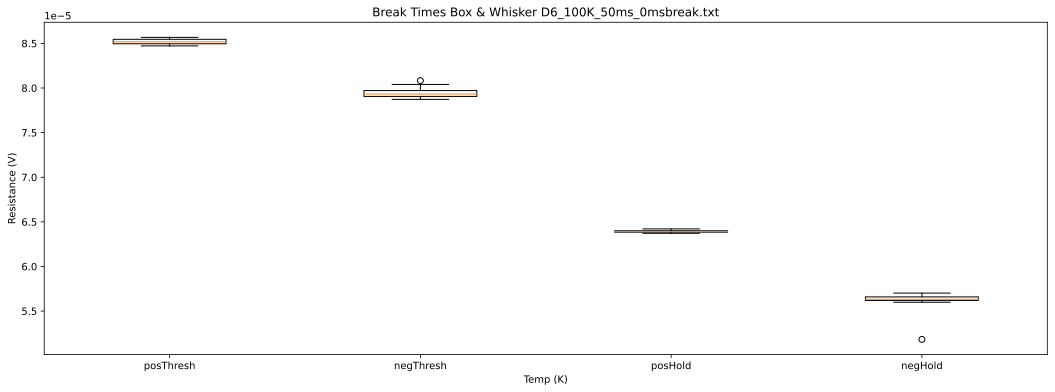

<Figure size 5400x1800 with 0 Axes>

[[8.738858e-05, 8.697969e-05, 8.7075e-05, 8.713004e-05, 8.687995e-05, 8.707028e-05, 8.680628e-05, 8.72602e-05, 8.736103e-05, 8.668208e-05, 8.689058e-05, 8.697531e-05, 8.675086e-05, 8.670937e-05, 8.68079e-05, 8.680108e-05, 8.693343e-05, 8.685768e-05, 8.676806e-05, 8.696782e-05, 8.692219e-05, 8.704164e-05, 8.701751e-05, 8.670394e-05, 8.681543e-05, 8.67353e-05, 8.67971e-05, 8.689217e-05, 8.678473e-05, 8.680113e-05, 8.702644e-05, 8.681113e-05, 8.662279e-05, 8.648902e-05, 8.673488e-05, 8.685319e-05, 8.673664e-05, 8.666416e-05, 8.662819e-05, 8.66723e-05, 8.662668e-05, 8.676341e-05, 8.645478e-05, 8.646598e-05, 8.632367e-05, 8.673824e-05, 8.639465e-05], [8.149388e-05, 8.100698e-05, 8.07388e-05, 8.088853e-05, 8.103154e-05, 8.057023e-05, 8.032566e-05, 8.098261e-05, 8.083329e-05, 8.037887e-05, 8.07065e-05, 8.039125e-05, 8.050179e-05, 8.060805e-05, 8.080137e-05, 8.03029e-05, 8.110188e-05, 8.088429e-05, 8.016609e-05, 8.024726e-05, 8.038992e-05, 8.011526e-05, 8.062219e-05, 8.056209e-05, 8.030657e-05

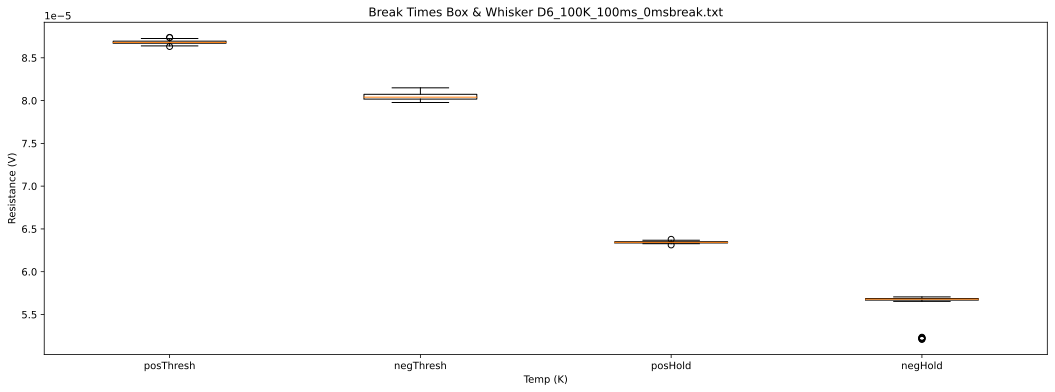

<Figure size 5400x1800 with 0 Axes>

[[8.922047e-05, 8.920718e-05, 8.901038e-05, 8.889012e-05, 8.905057e-05, 8.916e-05, 8.906754e-05, 8.889937e-05, 8.854219e-05, 8.856248e-05, 8.862971e-05, 8.872375e-05, 8.860786e-05, 8.875061e-05, 8.851592e-05, 8.823027e-05, 8.819487e-05, 8.861414e-05, 8.827905e-05, 8.832581e-05, 8.860107e-05, 8.810341e-05, 8.796385e-05, 8.813155e-05, 8.805015e-05, 8.817631e-05, 8.812648e-05, 8.813064e-05, 8.787401e-05, 8.775716e-05, 8.782329e-05, 8.788818e-05, 8.82047e-05, 8.812902e-05, 8.788414e-05, 8.819969e-05, 8.795193e-05, 8.767939e-05, 8.796959e-05, 8.78621e-05, 8.780225e-05, 8.779835e-05, 8.743665e-05, 8.780074e-05, 8.739434e-05, 8.749872e-05, 8.778313e-05], [7.427957e-05, 8.393647e-05, 8.416151e-05, 8.366157e-05, 8.372077e-05, 8.354763e-05, 8.370118e-05, 8.323566e-05, 8.256883e-05, 8.247446e-05, 8.254181e-05, 8.252305e-05, 8.297586e-05, 8.25262e-05, 8.25031e-05, 8.194312e-05, 8.24153e-05, 8.298432e-05, 8.255705e-05, 8.205645e-05, 8.228116e-05, 8.297469e-05, 8.192251e-05, 8.248042e-05, 8.139246e-

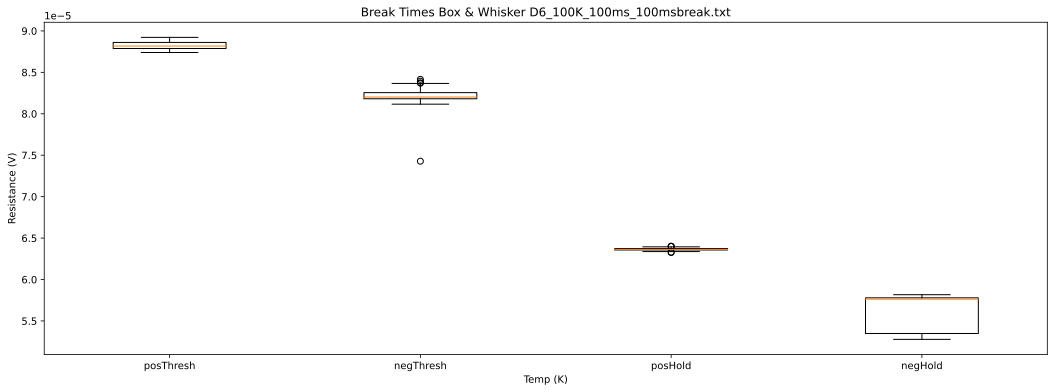

<Figure size 5400x1800 with 0 Axes>

[[8.233534e-05, 8.216089e-05, 8.216694e-05, 8.208416e-05, 9.180616e-05, 8.185564e-05, 9.216726e-05, 9.171893e-05, 9.184881e-05, 9.165987e-05, 8.19024e-05, 9.200293e-05, 9.198845e-05, 9.158258e-05, 9.188352e-05, 9.139437e-05, 9.161646e-05, 9.16486e-05, 9.176035e-05, 9.17533e-05, 9.134594e-05, 9.169861e-05, 9.180162e-05, 9.145407e-05, 9.165253e-05, 9.169926e-05, 9.156327e-05, 9.194161e-05, 9.187184e-05, 9.181322e-05, 9.171493e-05, 9.152757e-05, 9.147498e-05, 9.164301e-05, 9.206379e-05, 9.176229e-05, 9.217954e-05, 9.182459e-05, 9.184497e-05, 9.169593e-05, 9.170599e-05, 9.197296e-05, 9.184453e-05, 9.189719e-05, 9.174478e-05, 9.186594e-05, 9.164001e-05], [7.764558e-05, 7.696093e-05, 7.715762e-05, 7.636908e-05, 7.648387e-05, 7.624808e-05, 7.676636e-05, 7.592909e-05, 7.619429e-05, 7.611756e-05, 7.611424e-05, 7.615986e-05, 7.571217e-05, 7.558094e-05, 7.525245e-05, 7.526181e-05, 7.537685e-05, 7.565819e-05, 7.533257e-05, 7.548115e-05, 7.593123e-05, 7.542743e-05, 7.527983e-05, 7.507523e-05, 7.520

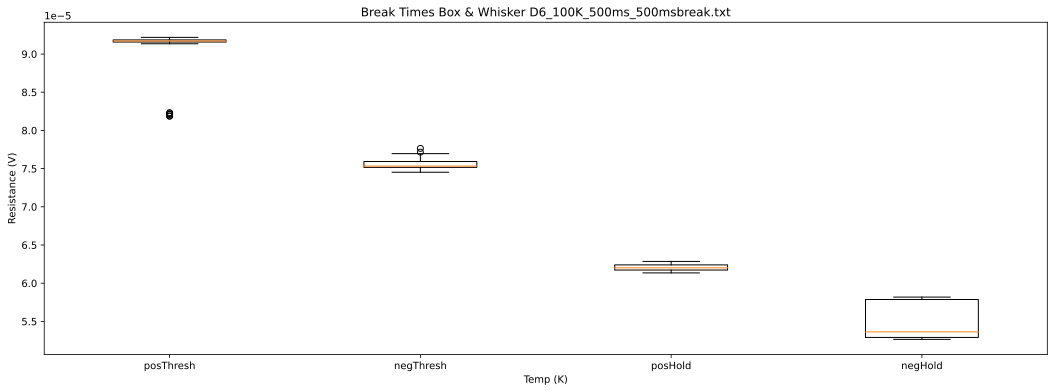

<Figure size 5400x1800 with 0 Axes>

[[8.379723e-05, 8.402896e-05, 8.352145e-05, 8.37097e-05, 8.353077e-05, 8.358897e-05, 8.305513e-05, 8.333155e-05, 8.356926e-05, 8.347433e-05, 8.342132e-05, 8.363776e-05, 8.373809e-05, 8.366109e-05, 8.387728e-05, 8.411148e-05, 8.40858e-05, 8.410747e-05, 8.425958e-05, 8.416823e-05, 8.414914e-05, 8.467231e-05, 8.422804e-05, 8.400692e-05, 8.430127e-05, 8.423968e-05, 8.45566e-05, 8.44305e-05, 8.455908e-05, 8.446586e-05, 8.45673e-05, 8.468652e-05, 8.467671e-05, 8.478889e-05, 8.439658e-05, 8.483504e-05, 8.482404e-05, 8.495762e-05, 8.488431e-05, 8.492242e-05, 8.485022e-05, 8.50124e-05, 8.480767e-05, 8.49958e-05, 8.509182e-05, 8.483508e-05, 8.497455e-05], [7.173332e-05, 7.257258e-05, 7.246084e-05, 7.231287e-05, 7.253449e-05, 7.222382e-05, 7.145635e-05, 7.156433e-05, 7.231256e-05, 7.189847e-05, 7.170853e-05, 7.157808e-05, 7.178824e-05, 7.233729e-05, 7.239734e-05, 7.270957e-05, 7.200812e-05, 7.221673e-05, 7.176505e-05, 7.247966e-05, 7.241177e-05, 7.18462e-05, 7.121004e-05, 7.126651e-05, 7.133224e-

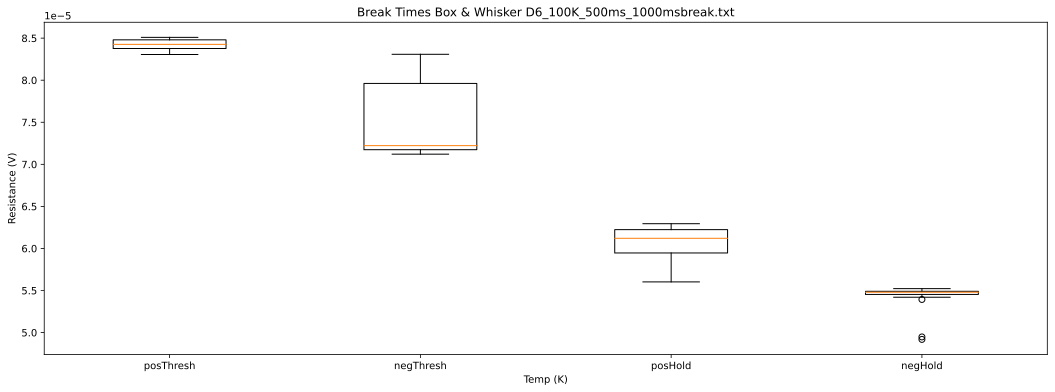

<Figure size 5400x1800 with 0 Axes>

In [156]:
# theFile = DataFile("c:/Users/Ted Mburu/Documents/GitHub/Nb02_v2/IVs_NbO2_Ti0_Sam3_052423_D15_cool.txt");
# theFile = DataFile(os.getcwd() + "/IVs_NbO2_Ti0_Sam3_052423_D15_cool.txt");

# newest file: IVs_NbO2_Ti0_2nd_Sam2_053023_D13_cool

theFiles = [
    DataFile("c:/Users/Ted Mburu/Documents/GitHub/NbO2-Fall-23/summerData/IVs_NbO2_Ti0_2nd_Sam7_080823_D6_100K_5ms_0msbreak.txt"),
    DataFile("c:/Users/Ted Mburu/Documents/GitHub/NbO2-Fall-23/summerData/IVs_NbO2_Ti0_2nd_Sam7_080823_D6_100K_50ms_0msbreak.txt"),
    DataFile("c:/Users/Ted Mburu/Documents/GitHub/NbO2-Fall-23/summerData/IVs_NbO2_Ti0_2nd_Sam7_080823_D6_100K_100ms_0msbreak.txt"),
    DataFile("c:/Users/Ted Mburu/Documents/GitHub/NbO2-Fall-23/summerData/IVs_NbO2_Ti0_2nd_Sam7_080823_D6_100K_100ms_100msbreak.txt"),
    DataFile("c:/Users/Ted Mburu/Documents/GitHub/NbO2-Fall-23/summerData/IVs_NbO2_Ti0_2nd_Sam7_080823_D6_100K_500ms_500msbreak.txt"),
    DataFile("c:/Users/Ted Mburu/Documents/GitHub/NbO2-Fall-23/summerData/IVs_NbO2_Ti0_2nd_Sam7_080823_D6_100K_500ms_1000msbreak.txt")
]

data_to_graph = []

for file in theFiles:
    # data_to_graph.append(file.return_voltage_vs_temp())
    # file.graph_voltage_vs_temp()
    the_graph = Graph(
            "Break Times Box & Whisker " + file.file_name[29:],   # title
            "Temp (K)",                             # xlabel
            "Resistance (V)",                          # ylabel
            [],                                     # hlines
            "box",                                  # type of graph
            file.return_voltage_vs_temp(),                          # data to graph
            ["posThresh", "negThresh", "posHold", "negHold"],                                     # labels of box plot
        )

   



# the_graph = Graph(
#             "Break Times Box & Whisker",   # title
#             "Temp (K)",                             # xlabel
#             "Resistance (V)",                          # ylabel
#             [],                                     # hlines
#             "box",                                  # type of graph
#             [data_to_graph],                          # data to graph
#             [],                                     # points
#         )





# theFile = DataFile("c:/Users/Ted Mburu/Documents/GitHub/NbO2-Fall-23/summerData/IVs_NbO2_Ti0_2nd_Sam7_080823_D6_100K_5ms_0msbreak.txt");


# theFile.graph_all_data()
# theFile.graph_IV_curves(2)
# theFile.graph_IV_curve(10)
# theFile.graph_voltage_vs_temp()





# theFile.graph_voltage_vs_resistance()
# theFile.graph_resistance_vs_temp()

# theFile.
# data_to_graph = [[], [], [], []]
# typeOfData = "posThresh"
# data_to_graph[0] = theFile.get_voltages_of_type(typeOfData)
# typeOfData = "posThresh"
# data_to_graph[1] = theFile.get_voltages_of_type(typeOfData)
# typeOfData = "posThresh"
# data_to_graph[2] = theFile.get_voltages_of_type(typeOfData)
# typeOfData = "posThresh"
# data_to_graph[3] = theFile.get_voltages_of_type(typeOfData)
# print(data_to_graph)
# the_graph = Graph(
#         "R vs Temp " + typeOfData,              # title
#         "Temp (K)",      # xlabel
#         "Resistance (Ω)",      # ylabel
#         [],                 # hlines
#         "semilogy",         # type of graph
#         [],      # data to graph
#         [data_to_graph],    # points
#     )
# data_to_graph = theFile.get_voltages_of_type("negThresh")





# theFile.graph_voltage_vs_temp_type("negThresh")
# theFile.graph_voltage_vs_temp_type("posHold")
# theFile.graph_voltage_vs_temp_type("negHold")
# # theFile.graph_voltage_vs_temp()
# # theFile.graph_resistance_vs_temp(0.2)
# # theFile.graph_resistance_vs_temp(0.3)

# for i in range(4, 6, 1):
#     index = i / 10
#     theFile.graph_resistance_vs_temp(index, "posThresh")
#     theFile.graph_resistance_vs_temp(index, "negThresh")
#     theFile.graph_resistance_vs_temp(index, "posHold")
#     theFile.graph_resistance_vs_temp(index, "negHold")

# theFile.graph_resistance_vs_temp(0.5)
# theFile.graph_resistance_vs_temp(0.6)
# theFile.graph_resistance_vs_temp(0.7)
# theFile.graph_resistance_vs_temp(0.8)
# theFile.graph_IV_curves_at_temp(84, 87)








# resistance as a function of temp as it cools. 4 graphs. 








# fig, ax = plt.subplots()

# # index_to_graph = self.IV_curves[index + i]['max_ddI'] + fine_tune
# # points_to_graph.append([voltage[index_to_graph], current[index_to_graph]])

# line, = ax.semilogy(0.0000000001, 0.0000001)
# # point = ax.plot(1, 1, marker="o", markersize=10, markeredgecolor='red', markerfacecolor='red')
# plt.xlim([-2, 2])
# plt.ylim([0.000000001, 0.003])
# plt.xlabel("Voltage (V)")
# plt.ylabel("Current (A)")
# plt.grid()


# def animate(i):

#     x = []
#     y = []
    
#     normal_i = i
#     i = i * (int)(len(theFile.IV_curves) / 100)

#     print("progress ", i, "/", len(theFile.IV_curves))

#     points_to_graph = []

#     # print("range: ", len(theFile.IV_curves[0]['V'] - 1))
#     for index in range(len(theFile.IV_curves[i]['V']) - 1):

#         four_curves_x = [
#             theFile.IV_curves[i + 0]['V'].tolist(),
#             theFile.IV_curves[i + 1]['V'].tolist(),
#             theFile.IV_curves[i + 2]['V'].tolist(),
#             theFile.IV_curves[i + 3]['V'].tolist(),
#             ]
        
#         four_curves_y = [
#             theFile.IV_curves[i + 0]['I'].tolist(),
#             theFile.IV_curves[i + 1]['I'].tolist(),
#             theFile.IV_curves[i + 2]['I'].tolist(),
#             theFile.IV_curves[i + 3]['I'].tolist(),
#             ]
        
#         fine_tune = 0
#         index_to_graph = [
#             theFile.IV_curves[i + 0]['max_ddI'] + fine_tune,
#             theFile.IV_curves[i + 1]['max_ddI'] + fine_tune,
#             theFile.IV_curves[i + 2]['max_ddI'] + fine_tune,
#             theFile.IV_curves[i + 3]['max_ddI'] + fine_tune,
#             ]
        
#         points_to_graph = [
#             [theFile.IV_curves[i + 0]['V'][index_to_graph[0]], theFile.IV_curves[i + 0]['I'][index_to_graph[0]]],
#             [theFile.IV_curves[i + 1]['V'][index_to_graph[1]], theFile.IV_curves[i + 1]['I'][index_to_graph[1]]],
#             [theFile.IV_curves[i + 2]['V'][index_to_graph[2]], theFile.IV_curves[i + 2]['I'][index_to_graph[2]]],
#             [theFile.IV_curves[i + 3]['V'][index_to_graph[3]], theFile.IV_curves[i + 3]['I'][index_to_graph[3]]],
#         ]
        
#         # voltage = self.IV_curves[index + i]['V']
#         # current = self.IV_curves[index + i]['I']
#         # data_to_graph.append([voltage, current])

#         # fine_tune = 0
#         # type_of_data = self.IV_curves[index + i]['type_of_data']
#         # if type_of_data == "posThresh":
#         #     fine_tune = 1
#         # if type_of_data == "negThresh":
#         #     fine_tune = 1
#         # if type_of_data == "posHold":
#         #     fine_tune = -2
#         # if type_of_data == "negHold":
#         #     fine_tune = -2
        
#         # index_to_graph = self.IV_curves[index + i]['max_ddI'] + fine_tune
#         # points_to_graph.append([voltage[index_to_graph], current[index_to_graph]])
        
        
        
        
        
#         # print("V: ", four_curves_x)
#         # print("sum: ", sum(four_curves_x, []))
        
#         x.append(sum(four_curves_x, []))
#         y.append(sum(four_curves_y, []))

#         # print("type:", sum(x, []))



#         # 'time': self.time[start:stop],
#         # 'I': self.I[start:stop],
#         # 'dI': dI,
#         # 'ddI': ddI,
#         # 'V': self.V[start:stop],
#         # 'temps': self.temps[start:stop],
#         # 'temp': run_temp,
#         # 'temp_std': run_temp_std,
#         # 'type_of_data': sort_into_side(self.V[start:stop], self.I[start:stop]),
#         # 'max_ddI': np.argmax(ddI),


#         # print("points_to_graph: ", points_to_graph)
#         # for point in points_to_graph:
#         #     plt.plot(point[0], point[1], marker="o", markersize=10, markeredgecolor='red', markerfacecolor='red')
    
#     title_time = "  Time =" + str(round(theFile.IV_curves[i]['time'][0])) + " s"
#     title_temp = "  Temp =" + str(round(theFile.IV_curves[i]['temp'])) + " K" + " Std: " + str(round(theFile.IV_curves[i]['temp_std'], 3))
#     title = "IV curve # " + str(i) + title_time + title_temp + " " + theFile.file_name
#     ax.set_title(title)
#     line.set_xdata(sum(x, []))  # update the data.
#     line.set_ydata(sum(y, []))  # update the data.
#     return line,


# # ani = animation.FuncAnimation(
# #     fig, animate, interval=50, blit=True, save_count=100)
# #                 # time between frames (ms)    number of frames
# # ani.save(theFile.file_name[:-4] + ".gif")

# # plt.show()




asdf

[array([ 0.01549201,  0.08770157,  0.20058264,  0.03819352, -0.01460722,
        0.02111539, -0.13482095, -0.08848265, -0.11455102,  0.08667869]), array([ 9.99263673, 10.12220372, 10.29568627,  9.84784788,  9.72930246,
       10.28510653,  9.90588788, 10.12101943,  9.76574964,  9.92919236]), array([ 99.98270463,  99.78608395, 100.56526577, 100.16626844,
       100.20922027, 100.0332877 , 100.41068977, 100.02357321,
       100.26991191,  99.64559009])]


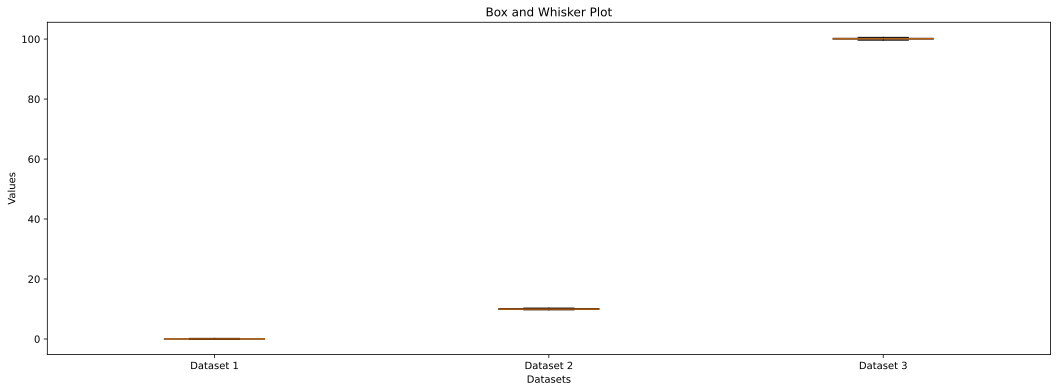

In [157]:
# four_curves_x = [
# theFile.IV_curves[5 + 0]['V'].tolist(),
# theFile.IV_curves[5 + 1]['V'].tolist(),
# theFile.IV_curves[5 + 2]['V'].tolist(),
# theFile.IV_curves[5 + 3]['V'].tolist(),
# ]
# print(theFile.file_name)
# print(type([1, 2, 3]))

# ini_list = four_curves_x
 
# # printing initial list
# print ("initial list ", str(ini_list))
 
# # converting 2d list into 1d
# flatten_list = sum(ini_list, [])
 
# # printing flatten_list
# print ("final_result", str(flatten_list))



# put everything on one Graph
# color code everything

# v vs r
# make gif for all files






# behaves as expected:
# IVs_NbO2_Ti0_2nd_Sam2_053023_D13_cool
# IVs_NbO2_Ti0_Sam3_051823_D22_opened
# IVs_NbO2_Ti0_Sam3_051823_D22 - very messy at the end
# IVs_NbO2_Ti0_Sam3_052423_D15_cool - very good
# IVs_NbO2_Ti10_Sam3_042023_D18_try2 - kinda messy at the end



# IVs_NbO2_Ti10_Sam3_042723_D18 - does nothing


data = [np.random.normal(0, 0.1, 10),
        np.random.normal(10, 0.2, 10),
        np.random.normal(100, 0.3, 10)]

print(data)


plt.boxplot(data, labels=['Dataset 1', 'Dataset 2', 'Dataset 3'])
plt.title('Box and Whisker Plot')
plt.xlabel('Datasets')
plt.ylabel('Values')
plt.show()